## CTR PREDICTION 
This study focuses on improving Click-Through Rate (CTR) prediction in online advertising and content recommendation systems. Accurate CTR prediction is vital for optimizing marketing efforts and enhancing user experiences. Key topics covered include effective feature engineering, hyperparameter tuning, and model performance measures. 

This notebook includes feature engineering steps for the dataset. 'model_development.ipynb' includes all model development and hyperparameter tuning processes by using the Weight&Bias platform.

The dataset used in this study is obtained from the Kaggle competition in the link below. 
https://www.kaggle.com/competitions/avazu-ctr-prediction/overview

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import sys

The dataset includes 3 different files; train, test, and submission. 

In this study, only random 10000 data points in the training dataset will be used to make quick analysis and model development. Subsampling will be done without considering class balance.

In [2]:
seed_value = 42  # seed for reproducibility
random.seed(seed_value)

n = 40428967  # total number of records in the clickstream data 
sample_size = 10000
skip_values = sorted(random.sample(range(1,n), n-sample_size)) # sort to skip with more efficient way
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

In [3]:
# indicate the datatypes to use in the reading process

dtype={'id': np.dtype(int),
    'click': np.dtype(int),
    'hour': np.dtype(str),
    'C1': np.dtype(str),
    'banner_pos': np.dtype(str),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(str),
    'device_conn_type': np.dtype(str),
    'C14': np.dtype(str),
    'C15': np.dtype(str),
    'C16': np.dtype(str),
    'C17': np.dtype(str),
    'C18': np.dtype(str),
    'C19': np.dtype(str),
    'C20': np.dtype(str),
    'C21':np.dtype(str)
      }#

In [4]:
# read whole datasets are given in the competition

train = pd.read_csv("/Users/fatmaoztel/Desktop/avazu-ctr-prediction/train", parse_dates=['hour'], date_parser=parse_date, dtype=dtype, skiprows=skip_values)
test = pd.read_csv("/Users/fatmaoztel/Desktop/avazu-ctr-prediction/test")
submission = pd.read_csv('/Users/fatmaoztel/Desktop/avazu-ctr-prediction/sampleSubmission')
print('Train dataset:',train.shape)
print('Test dataset:',test.shape)
print('Submission:',submission.shape)

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/3443798152.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')


Train dataset: (10000, 24)
Test dataset: (4577464, 23)
Submission: (4577464, 2)


The train dataset is recreated with the 10000 data points above, only it will be used.

### EDA & Feature Engineering

In this section, whole features will be analyzed to extract information by calculations and graphs. All features inside the dataset are categorical features.

But don't forget, there are a lot of unknown features, which makes this process hard. Nevertheless, the dataset absolutely includes valuable information, so this process should not be skipped before the training.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                10000 non-null  uint64        
 1   click             10000 non-null  int64         
 2   hour              10000 non-null  datetime64[ns]
 3   C1                10000 non-null  object        
 4   banner_pos        10000 non-null  object        
 5   site_id           10000 non-null  object        
 6   site_domain       10000 non-null  object        
 7   site_category     10000 non-null  object        
 8   app_id            10000 non-null  object        
 9   app_domain        10000 non-null  object        
 10  app_category      10000 non-null  object        
 11  device_id         10000 non-null  object        
 12  device_ip         10000 non-null  object        
 13  device_model      10000 non-null  object        
 14  device_type       10000

Features of CTR dataset;

* **id** : ad identifier
* **hour** : format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
* **banner_pos**
* **Target feature** : click (0,1)
* **Site features** : site_id, site_domain, site_category
* **App feature** : app_id, app_domain, app_category
* **Device feature** : device_id, device_ip, device_model, device_type, device_conn_type
* **Anonymized categorical features** : C1, C14-C21

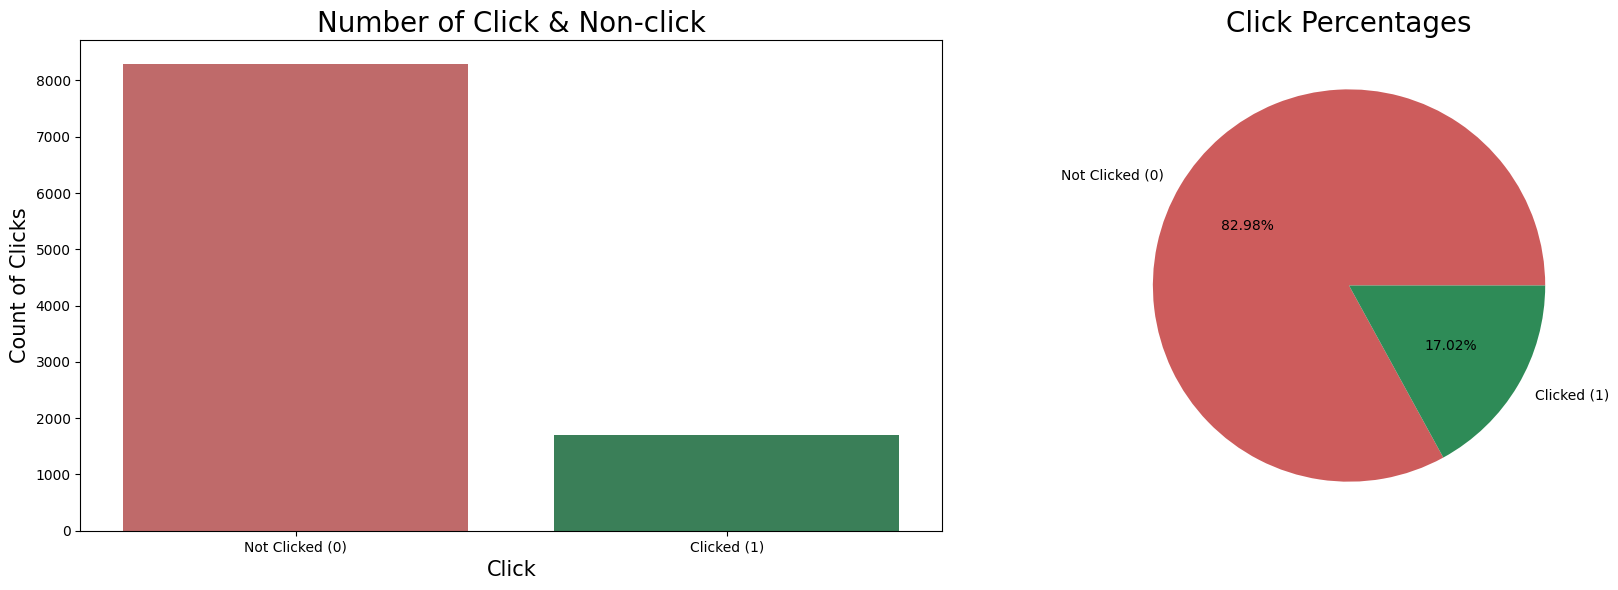

In [6]:
# create plots with target
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
#cols = ['r', 'g']
cols = ["IndianRed", "SeaGreen"]
labels = ['Not Clicked (0)', 'Clicked (1)']

# Plot 1: Countplot
sns.countplot(data=train, x='click', ax=axes[0], palette=cols)
axes[0].set_xlabel('Click', fontsize=15)
axes[0].set_ylabel('Count of Clicks', fontsize=15)
axes[0].set_title('Number of Click & Non-click', fontsize=20)
#axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_xticklabels(labels)

# Plot 2: Pie Chart
type_group = train.groupby('click').count()
type_group = type_group.reset_index()

axes[1].pie(type_group["id"], labels=labels, colors=cols, autopct='%1.2f%%')
axes[1].set_title('Click Percentages', fontsize=20)

# adjust the layout to prevent overlapping labels
plt.tight_layout()

plt.show()

The overall click-through rate is approx. 17%, and 83% is not clicked. The aim is increasing the clicked percentages finding more proper factors to reach the right customer at the right time and right place.

In [7]:
train.hour.describe()

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/1468264.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train.hour.describe()


count                   10000
unique                    240
top       2014-10-28 13:00:00
freq                      123
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

The data includes 10 days of click stream data from 2014–10–21 to 2014–10–30, which means 240 different hours. Our subsample includes value from each unique value.

Text(0.5, 1.0, 'Number of Clicks by Hour')

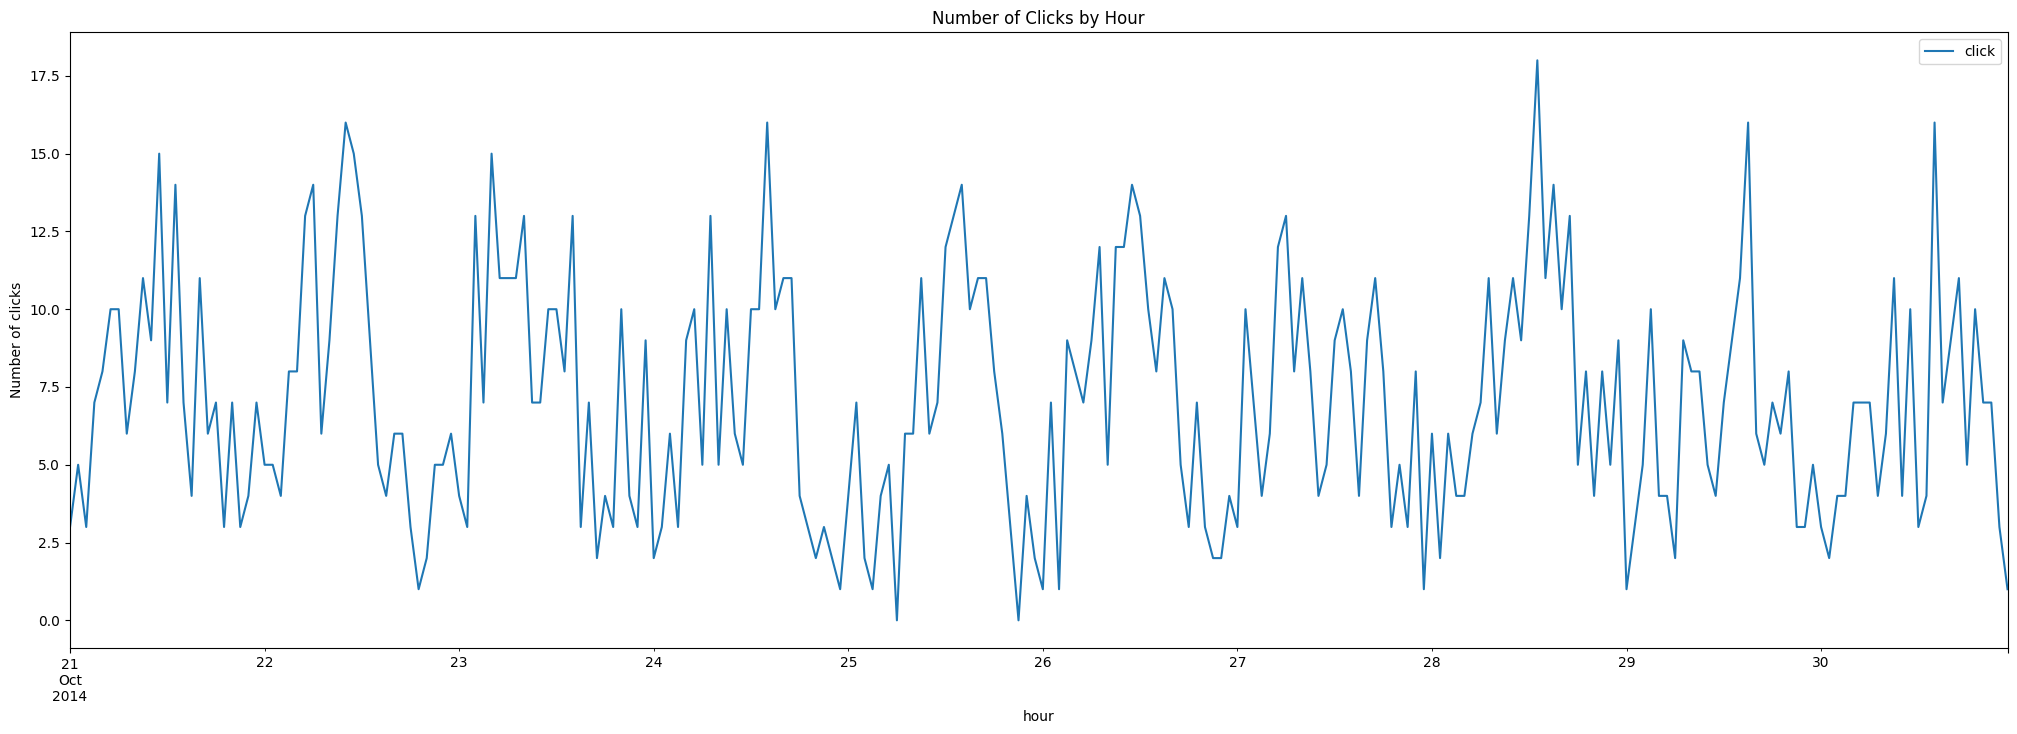

In [8]:
# group by hour of the days
train.groupby('hour').agg({'click':'sum'}).plot(figsize=(25,8))
plt.ylabel('Number of clicks')
plt.title('Number of Clicks by Hour')

As you can see above, there is no obvious trend or cycle depending on the hour of each day.

Text(0.5, 1.0, 'Click Trends by Hour of Day')

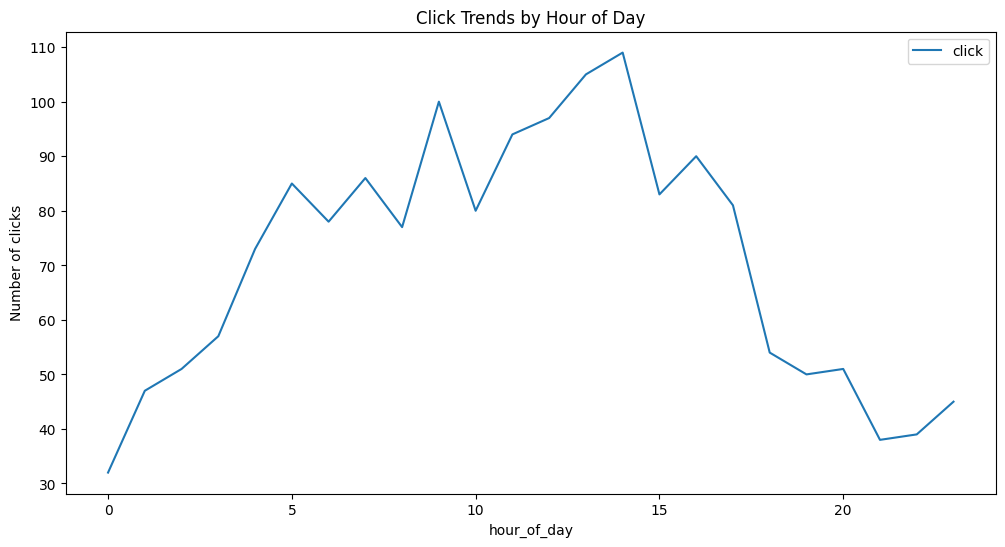

In [9]:
# aggregate hours
train['hour_of_day'] = train.hour.apply(lambda x: x.hour)
train.groupby('hour_of_day').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Click Trends by Hour of Day')

If you aggregate the total click according to the hour of days, we can say that the highest click is obtained from the 13-15 hours. Of course, we expect low clicks in the middle of the night.

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/552776810.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


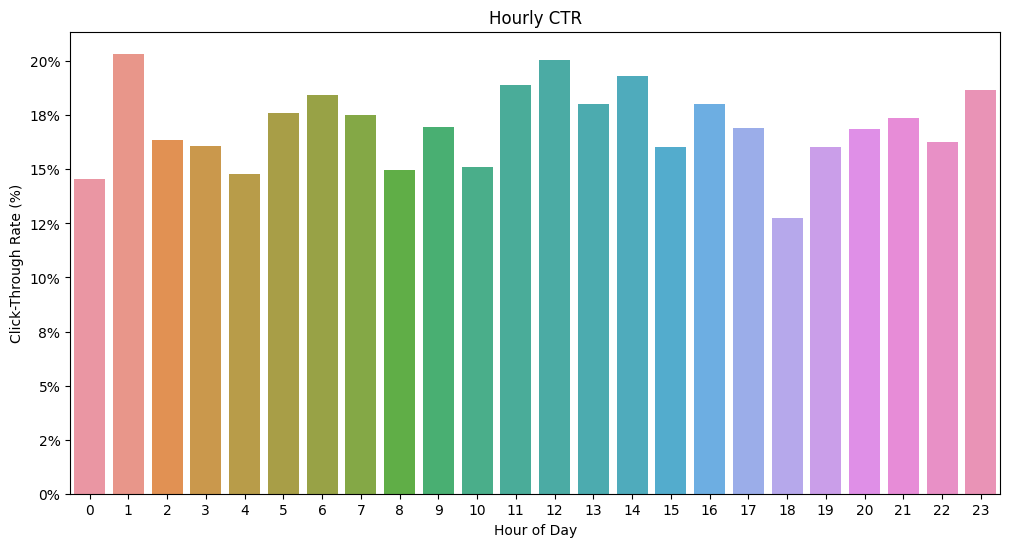

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

df_col = train.groupby(['hour_of_day', 'click']).size().unstack()
df_col.reset_index(inplace=True)

# calculate Click-Through Rate (CTR) per hour
df_col['CTR'] = df_col[1]/(df_col[1]+df_col[0])*100



# create a bar plot for hourly CTR
plt.figure(figsize=(12, 6))
sns.barplot(x='hour_of_day', y='CTR', data=df_col)
plt.title('Hourly CTR')
plt.ylabel('Click-Through Rate (%)')
plt.xlabel('Hour of Day')

plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


plt.show()


The highest CTR percentages are obtained the hours 1, 12, and 14. These should be considered to release and reach the right customers the advertisement in the proper hour.

Text(0.5, 1.0, 'Interaction vs. Clicks by Day of Week')

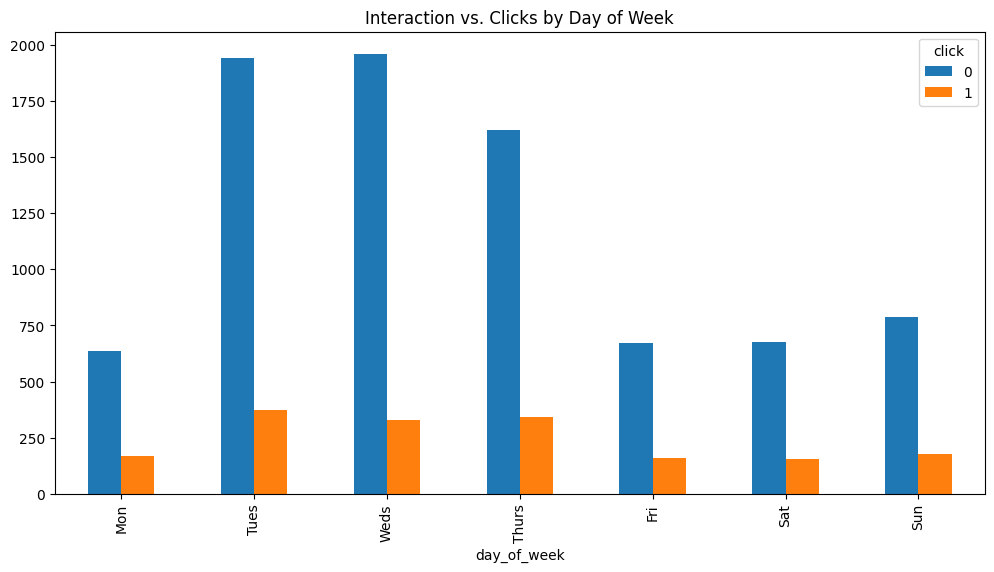

In [11]:
# aggregate the values according to the days of the week
train['day_of_week'] = train['hour'].apply(lambda val: val.day_name())
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

train.groupby(['day_of_week','click']).size().unstack().reindex(cats).plot(kind='bar', title="Day of the Week", figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('Interaction vs. Clicks by Day of Week')

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/1531942420.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


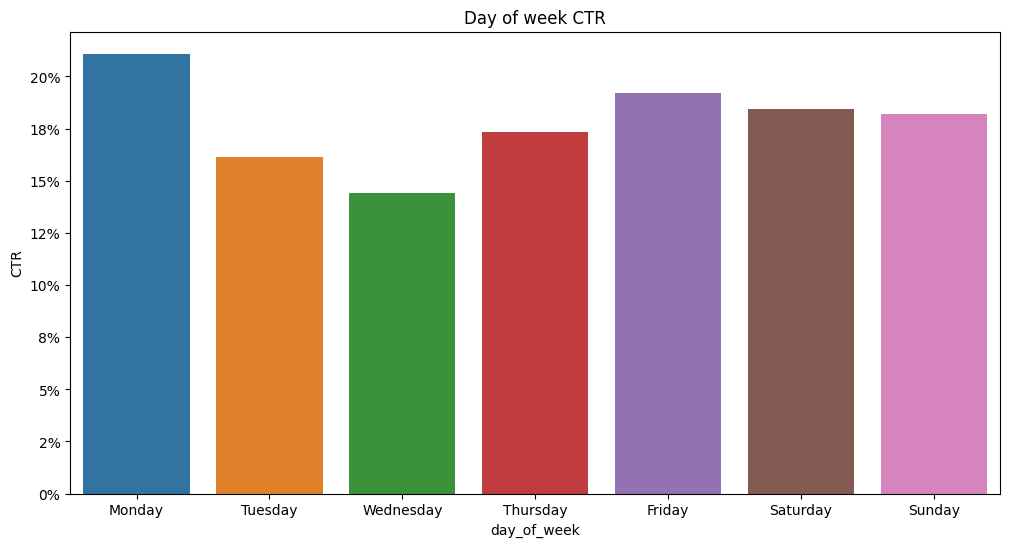

In [12]:
df_col = train.groupby(['day_of_week', 'click']).size().unstack()
df_col.reset_index(inplace=True)

# calculate Click-Through Rate (CTR) per week
df_col['CTR'] = df_col[1]/(df_col[1]+df_col[0])*100


plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='day_of_week', data=df_col, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of week CTR')
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])

plt.show()

Although Tuesday and Wednesday have the highest interaction, these days have low CTR relative to the weekend days. We can say that users or customers find more convenient times at the weekends. Also, Monday has the highest CTR, it should be searched, There should be a meaning for Monday syndrome :)

In [13]:
train.isna().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
hour_of_day         0
day_of_week         0
dtype: int64

No missing value to detect and handle. If we have missing value;

* Create a New Category as 'missing'
* Replace missing values with the most frequent category (mode)
* Fill in missing values according to domain knowledge
* Use Predictive Models for the columns that include missing values
* CatBoost can automatically handle missing values in categorical features during training
* As a last option, if a column has a very high percentage of missing values (e.g., 80% or more), it might be less informative and could potentially be removed from the dataset. But please take into account the domain knowledge before removing it. 

### Anonymized Categorical Features

Let's find the CTR values and draw graphs to extract the implicit values without knowing the features.

In [14]:
# keep all anonymized feature names in the list
acf = ["C1", "C14", "C15", "C16", "C17", "C18", "C19", "C20", "C21"]

In [15]:
# print all amount of categories inside the features
for column in acf: 
    print(f"Feature {column}:")
    print(train[column].value_counts(normalize=True))
    print('---------------------------------')

Feature C1:
1005    0.9193
1002    0.0547
1010    0.0216
1012    0.0027
1001    0.0008
1007    0.0008
1008    0.0001
Name: C1, dtype: float64
---------------------------------
Feature C14:
4687     0.0231
21611    0.0228
21191    0.0198
21189    0.0192
16208    0.0170
          ...  
22588    0.0001
22312    0.0001
21627    0.0001
6398     0.0001
23643    0.0001
Name: C14, Length: 944, dtype: float64
---------------------------------
Feature C15:
320    0.9298
300    0.0628
216    0.0058
728    0.0016
Name: C15, dtype: float64
---------------------------------
Feature C16:
50     0.9416
250    0.0479
36     0.0058
480    0.0031
90     0.0016
Name: C16, dtype: float64
---------------------------------
Feature C17:
1722    0.1130
2424    0.0390
2227    0.0332
1800    0.0303
2480    0.0231
         ...  
2394    0.0001
2436    0.0001
2611    0.0001
2438    0.0001
2725    0.0001
Name: C17, Length: 330, dtype: float64
---------------------------------
Feature C18:
0    0.4197
3    0.3382
2 

Only this result can be extracted from this category percentages of anonymized columns above; C1, C15, and C16 features have a class that has a percentage of value above 90%. Maybe, we can say roughly that these features can not have a significant effect on the target. But of course, we don't have any information about these features, so we should be careful in the training process.

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/440022970.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


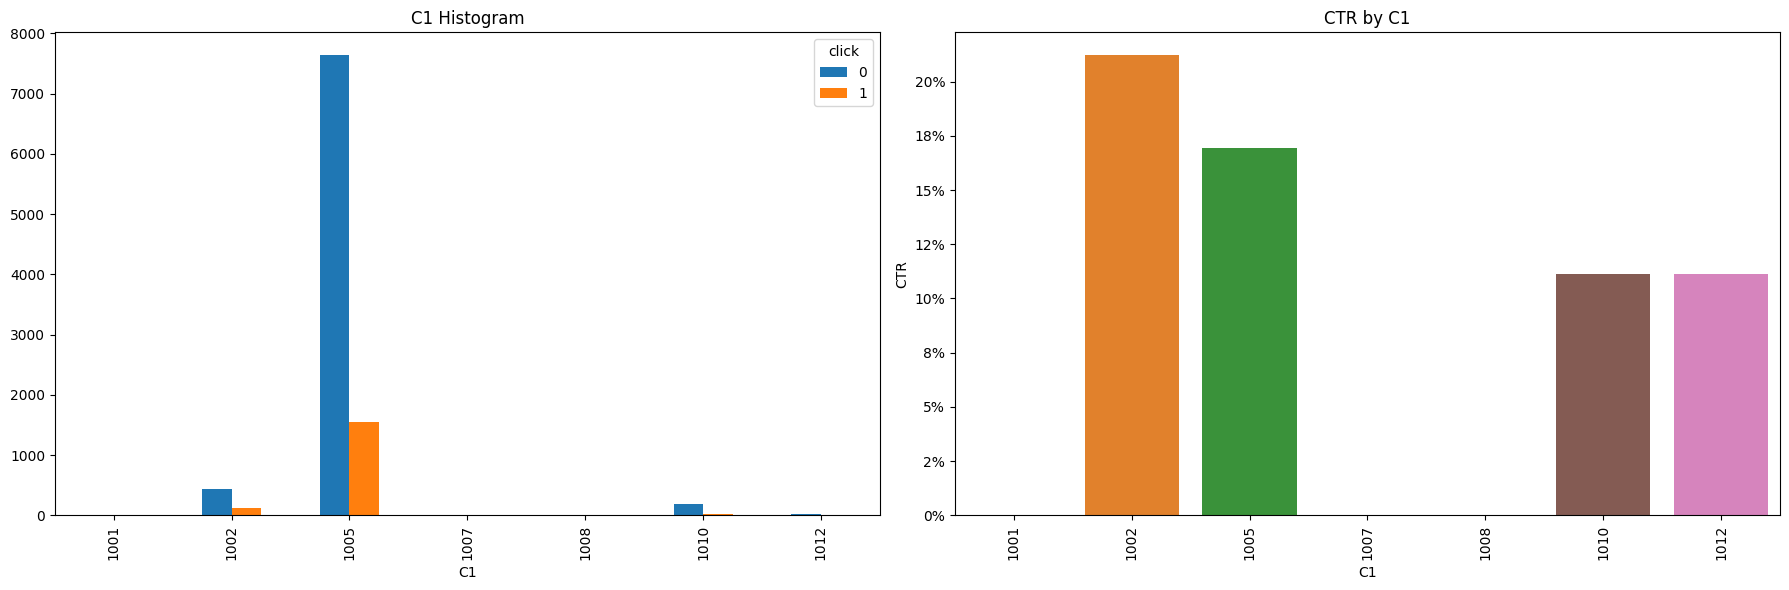

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/440022970.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


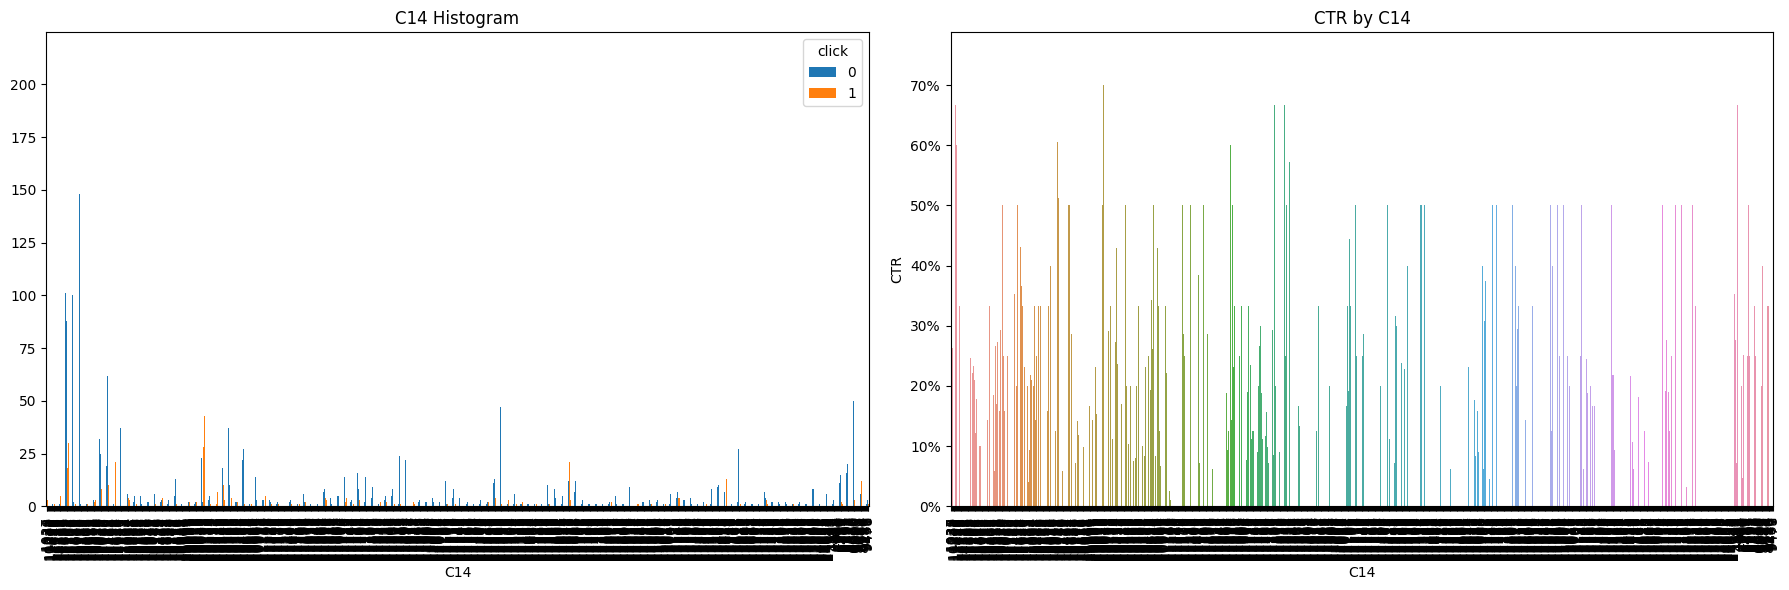

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/440022970.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


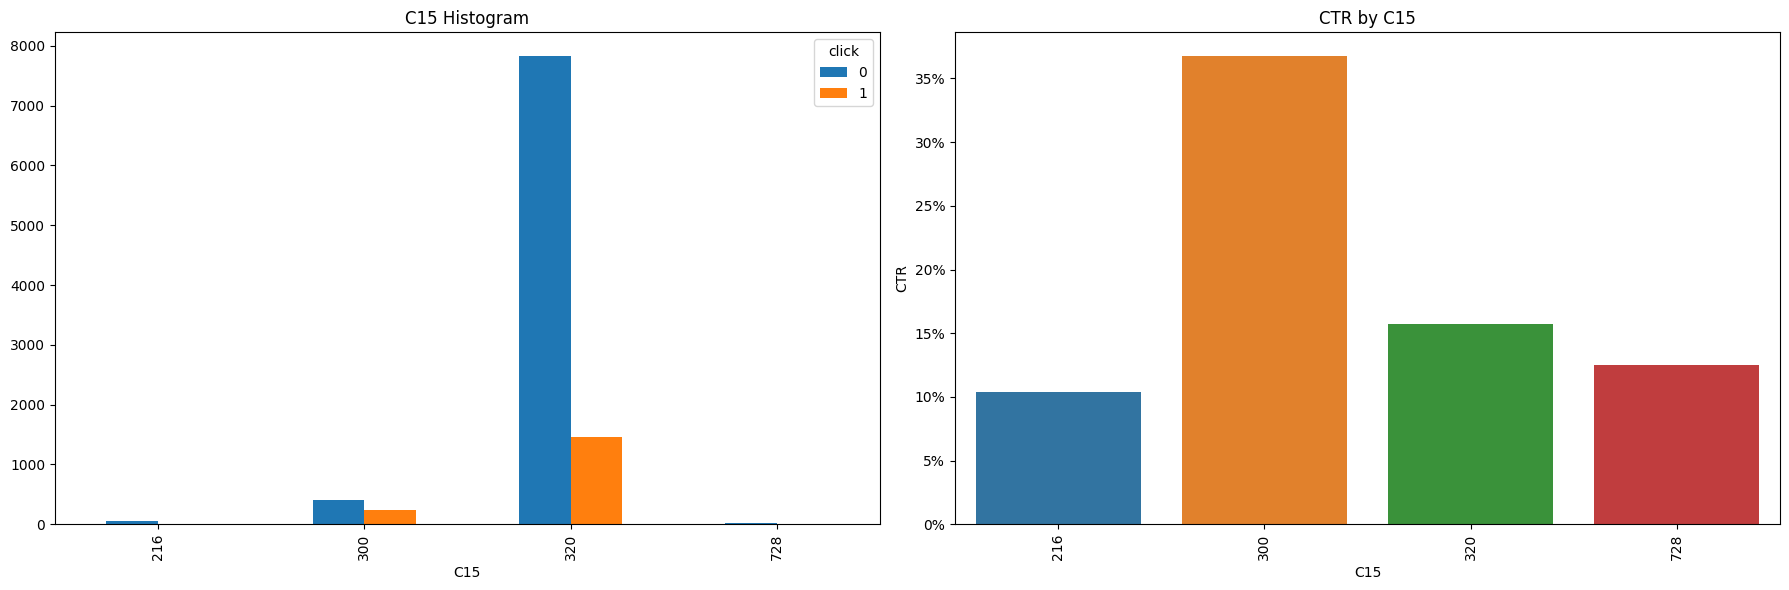

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/440022970.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


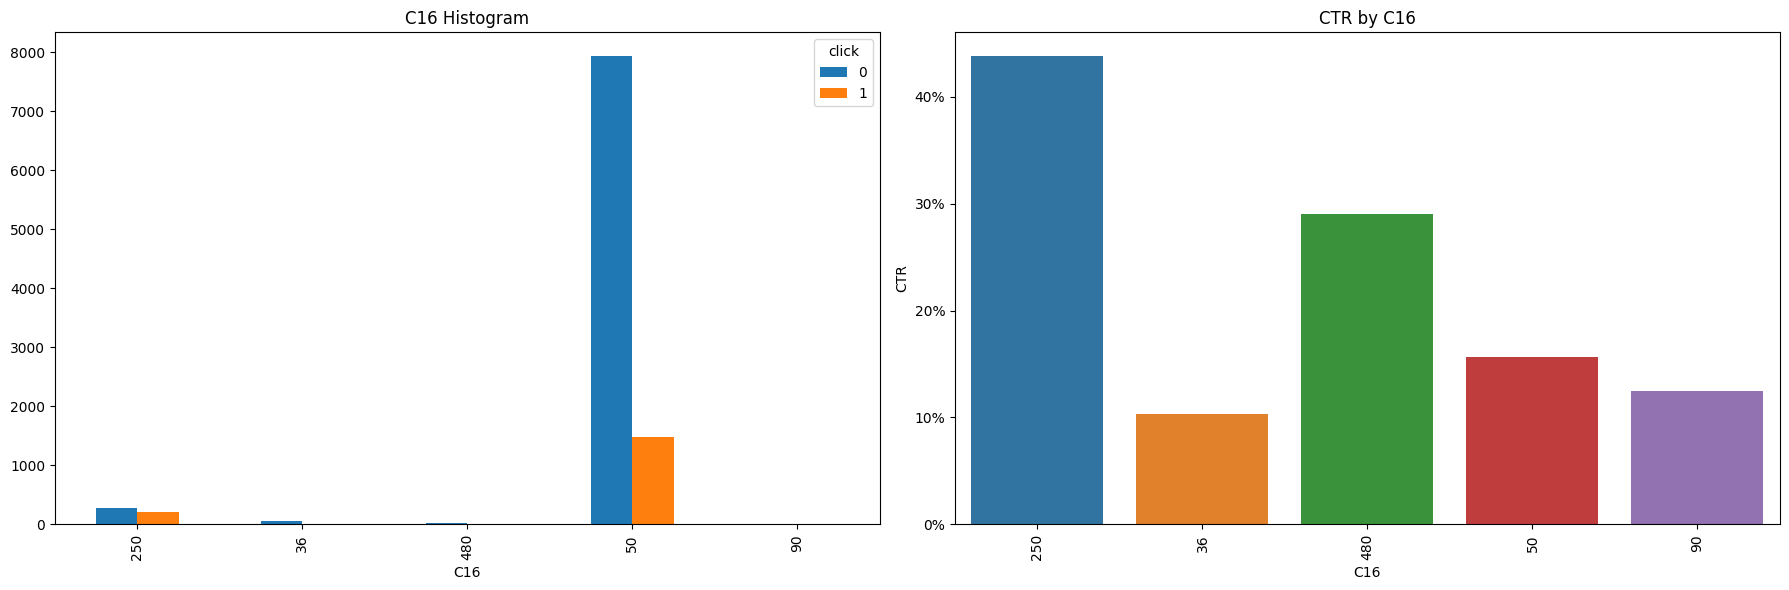

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/440022970.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


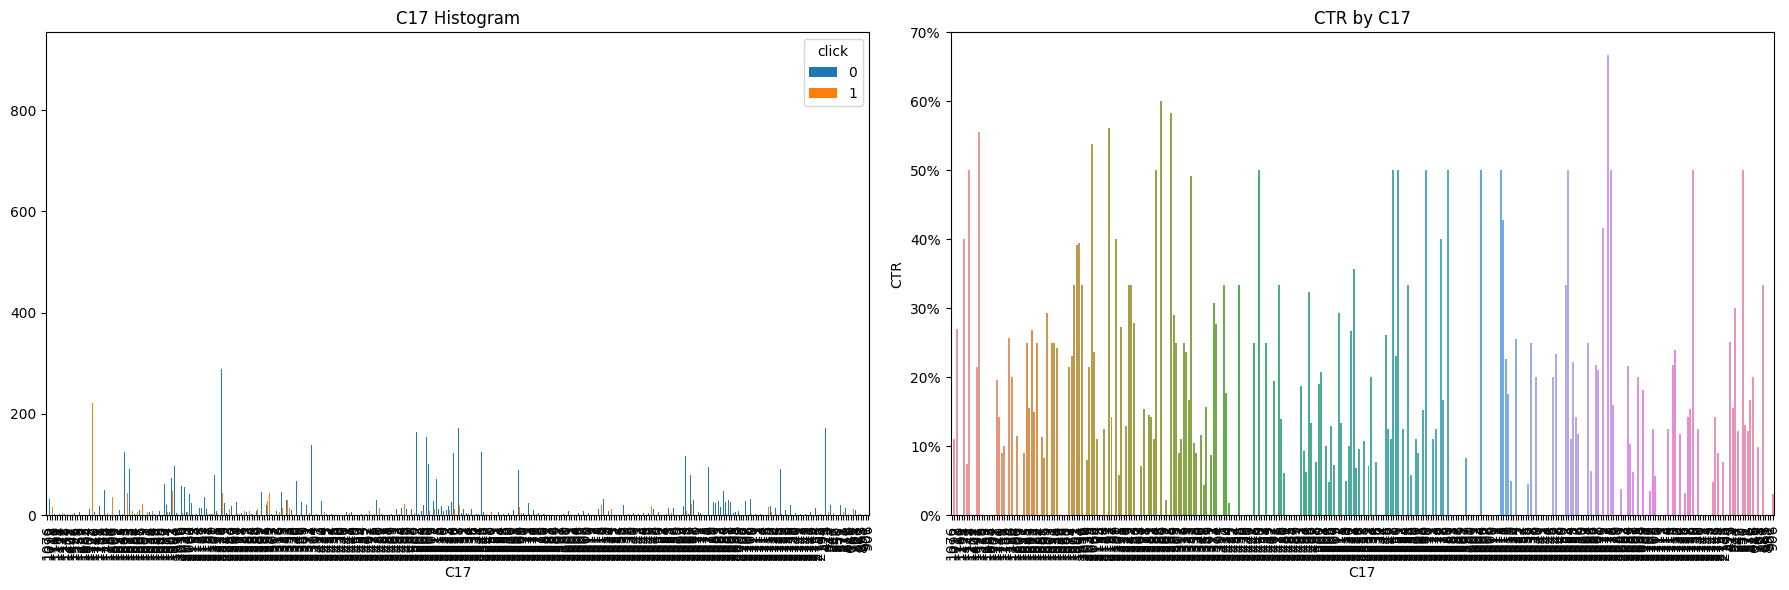

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/440022970.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


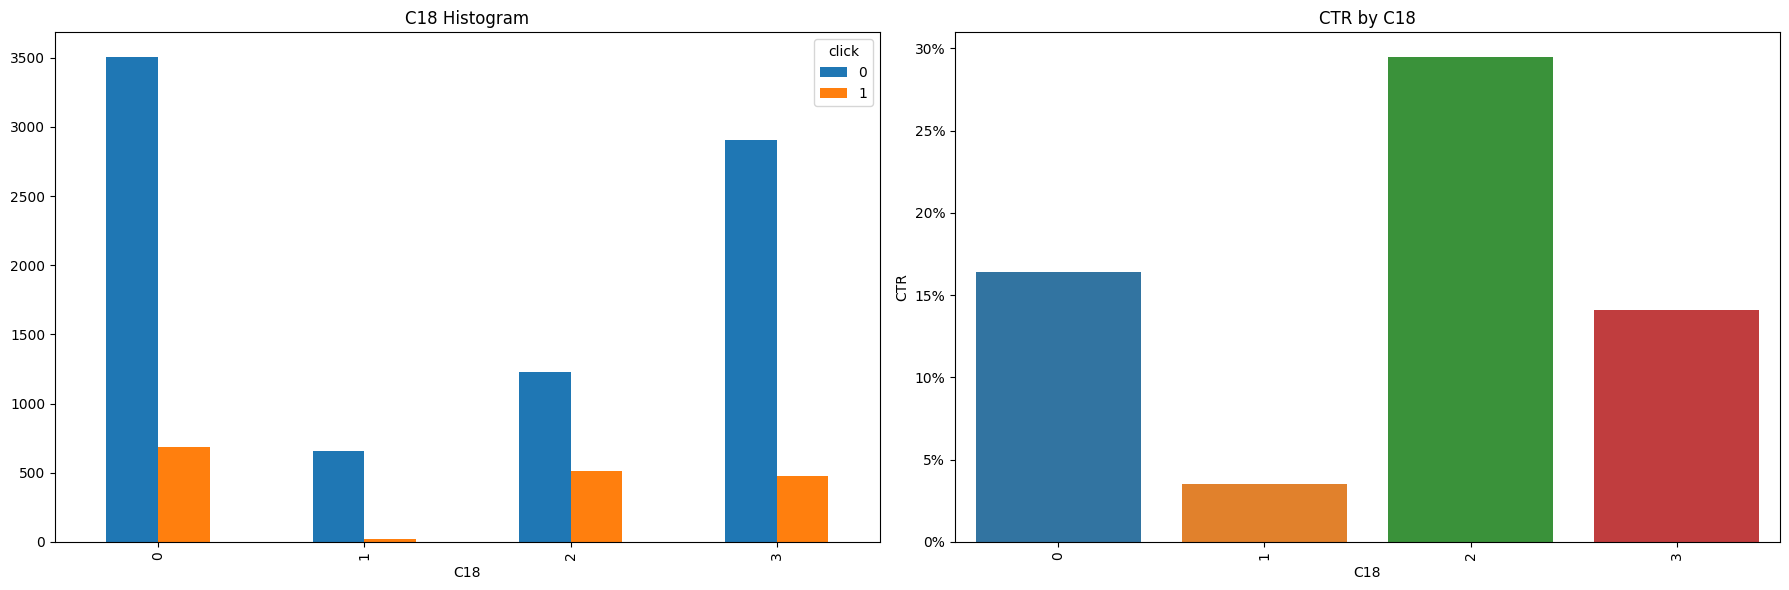

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/440022970.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


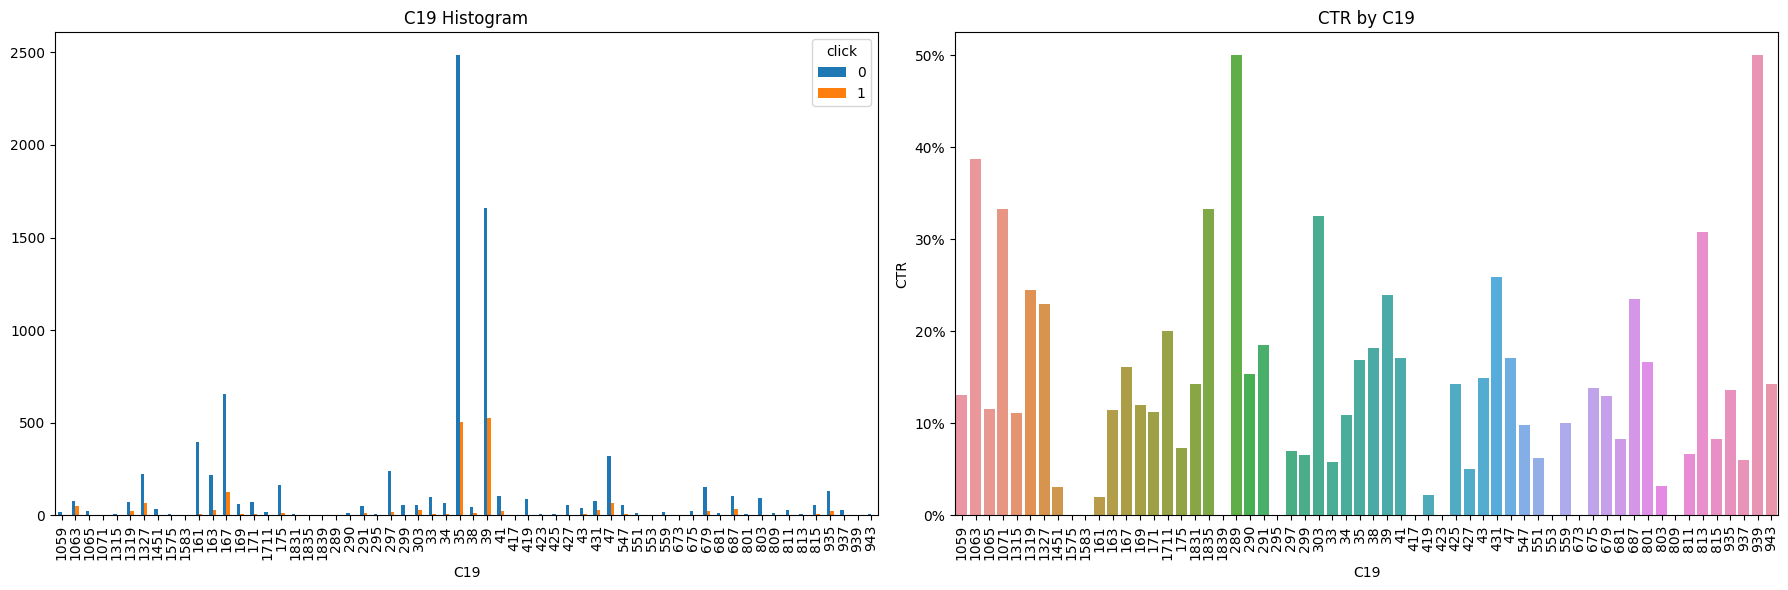

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/440022970.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


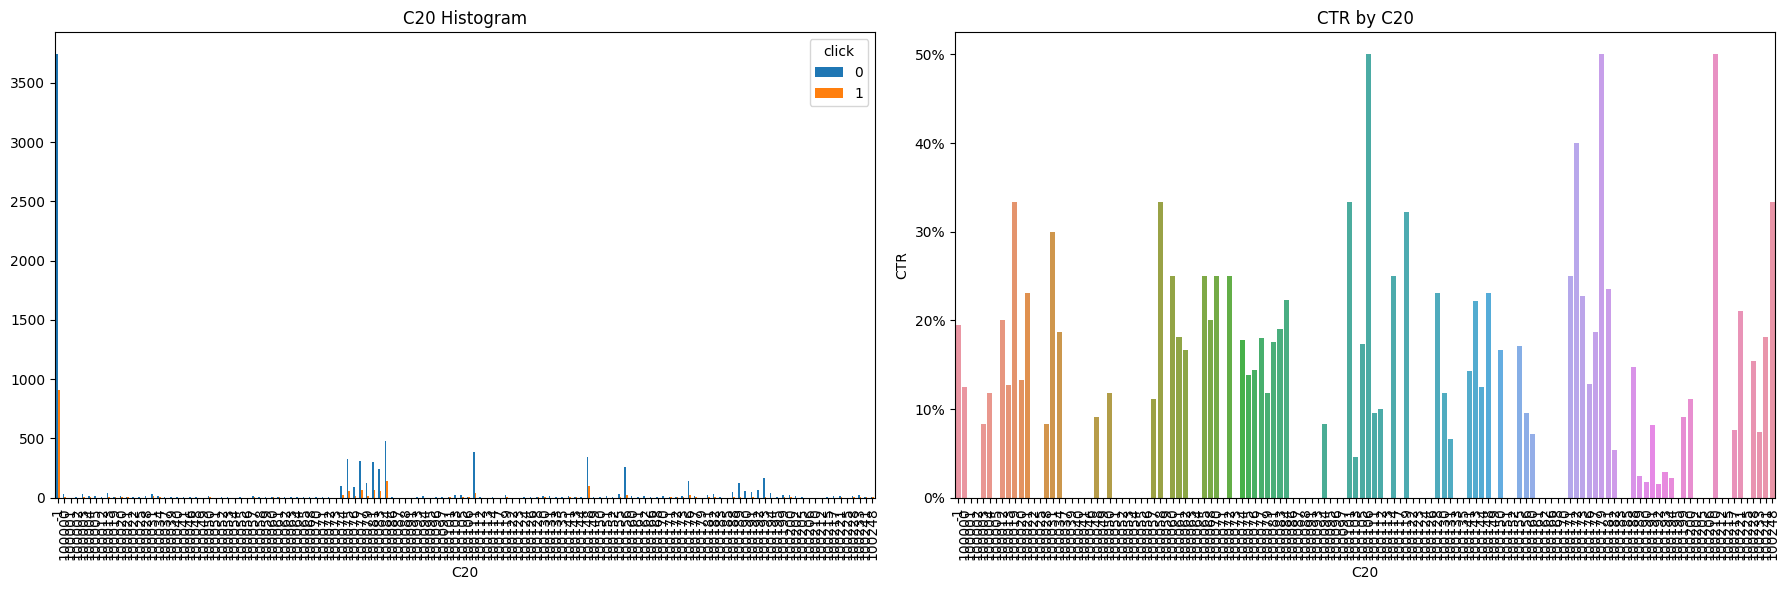

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/440022970.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


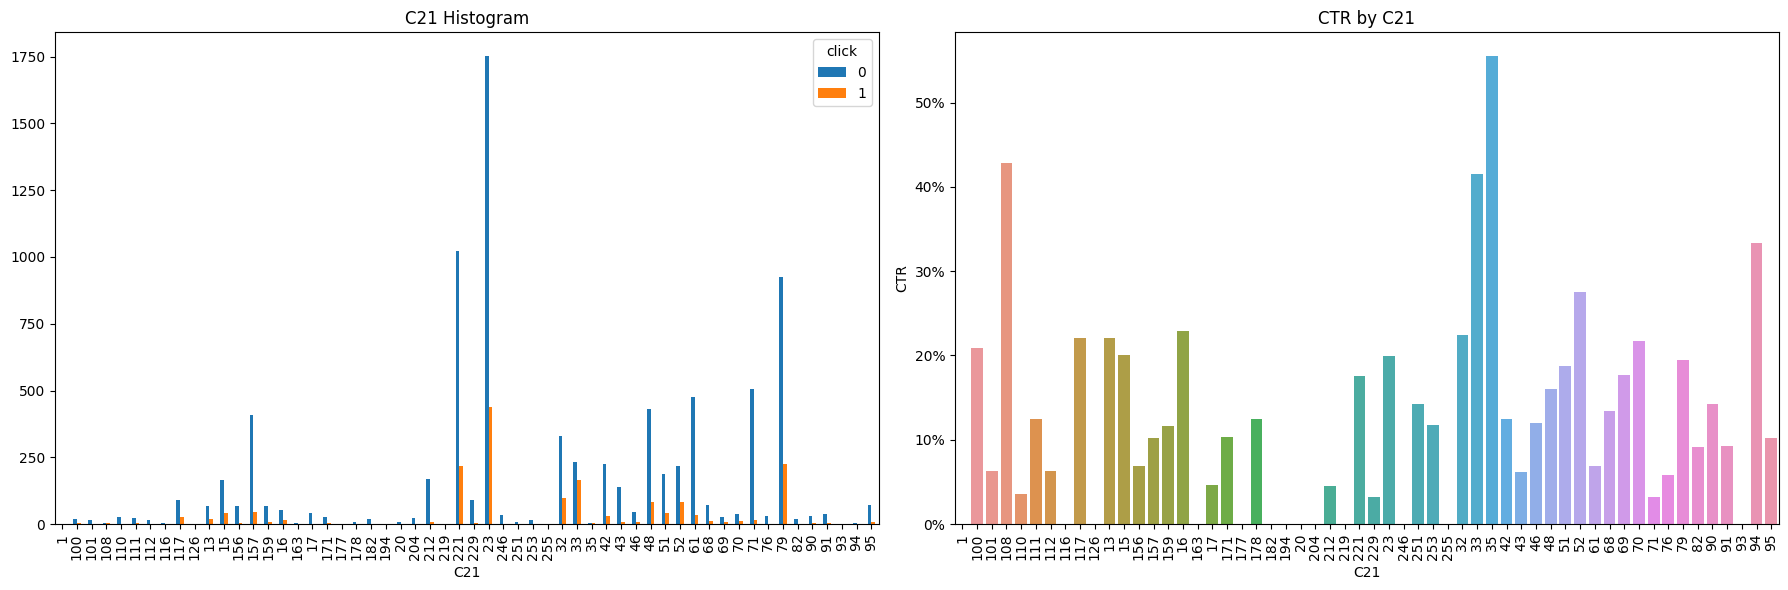

In [16]:
for column in acf: 
    # create a figure with two subplots
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    # plot the first graph
    train.groupby([column, 'click']).size().unstack().plot(kind='bar', ax=axs[0], title=f'{column} Histogram')
    axs[0].tick_params(axis='x', rotation=90)

    # plot the second graph
    df_col = train.groupby([column, 'click']).size().unstack()
    df_col.reset_index(inplace=True)

    # calculate Click-Through Rate (CTR) per column class
    df_col['CTR'] = df_col[1]/(df_col[1]+df_col[0])*100

    sns.barplot(y='CTR', x=column, data=df_col, ax=axs[1])
    axs[1].set_title(f'CTR by {column}')
    axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])
    axs[1].tick_params(axis='x', rotation=90)


    # adjust the layout and display the graphs
    plt.tight_layout()
    plt.show()

C14, C17, C19, C20, and C21 columns include categories that have 50% or higher than 50% CTR. These are important indicators to detect which categories in the features have high CTR. But of course, interaction count is also an important factor before detecting important categories, for example, the class only has 2 successful interactions, It's not enough to say that this class is really important for the target, it needs more samples to say that. So we should consider these 2 bar charts to conclude sensible results at the same time.

For example;
* C1=1005: 91.9% of the data and 0.17 CTR
* C1=1002: 5.4% of the data and 0.22 CTR
* C1=1010: 2.16% of the data and 0.11 CTR
C1 = 1002 has a much higher than average CTR, and C1=1010 has a much lower than average CTR, it seems these two C1 values are important for predicting CTR.

https://towardsdatascience.com/mobile-ads-click-through-rate-ctr-prediction-44fdac40c6ff

### Known Categorical Features

Let's make this for known features belonging to the app, site, etc.

In [17]:
# keep all known feature names in the list
kcf = ["banner_pos", "site_id", "site_domain", "site_category", "app_id", "app_domain", "app_category",
       "device_id", "device_ip", "device_model", "device_type", "device_conn_type"]

In [18]:
for column in kcf: 
    print(f"Feature {column}:")
    print(train[column].value_counts(normalize=True))
    print('---------------------------------')

Feature banner_pos:
0    0.7215
1    0.2764
7    0.0011
2    0.0005
4    0.0003
5    0.0001
3    0.0001
Name: banner_pos, dtype: float64
---------------------------------
Feature site_id:
85f751fd    0.3569
1fbe01fe    0.1654
e151e245    0.0610
5b08c53b    0.0254
d9750ee7    0.0243
             ...  
1d8321a3    0.0001
a1da74c0    0.0001
54e6fb06    0.0001
066a0884    0.0001
4019685f    0.0001
Name: site_id, Length: 575, dtype: float64
---------------------------------
Feature site_domain:
c4e18dd6    0.3696
f3845767    0.1654
7e091613    0.0797
7687a86e    0.0359
98572c79    0.0252
             ...  
f2303555    0.0001
91dd76e0    0.0001
121dec7d    0.0001
31eace6b    0.0001
0d2f20d2    0.0001
Name: site_domain, Length: 462, dtype: float64
---------------------------------
Feature site_category:
50e219e0    0.4038
f028772b    0.3138
28905ebd    0.1865
3e814130    0.0758
f66779e6    0.0062
75fa27f6    0.0041
335d28a8    0.0036
76b2941d    0.0025
dedf689d    0.0009
c0dd3be3    0.0009
70

Only this result can be extracted from this category percentages of anonymized columns above; device_id, device_type, and device_conn_type features have a class that has a percentage of value above 80%. These features are related to the device. We can say roughly that these device features can not have a significant effect on the target. But of course, we don't have any information about these features, maybe the connection provided by devices can affect the instant click, so we should be careful in the training process.

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/3246866625.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


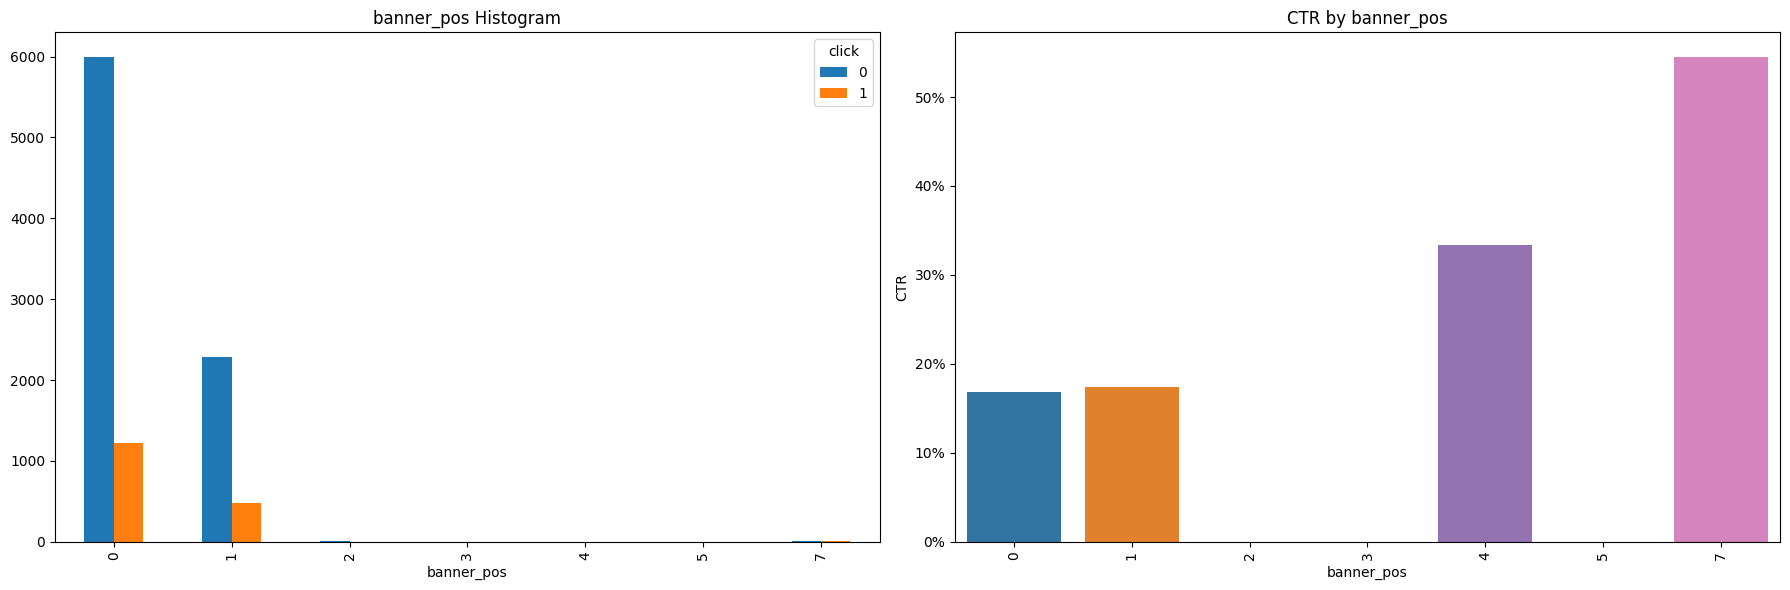

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/3246866625.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


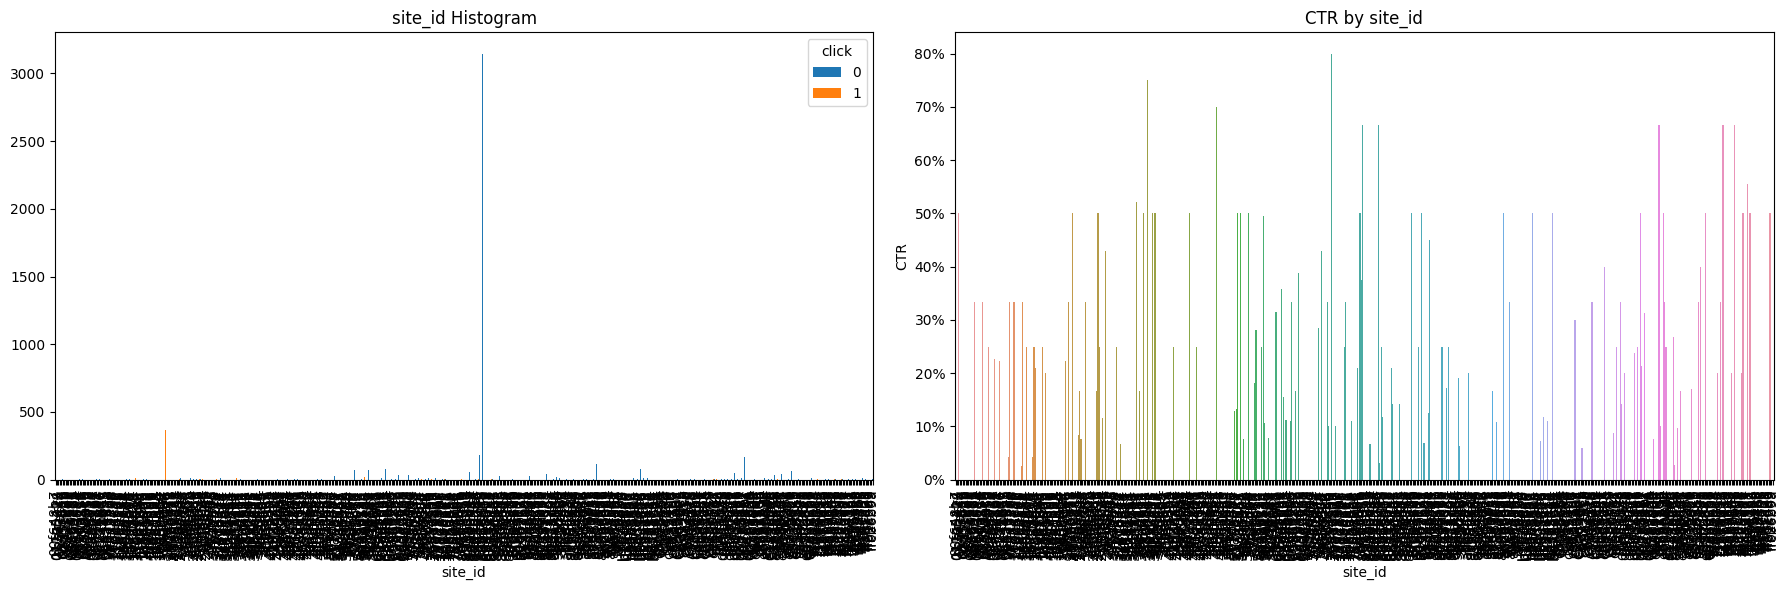

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/3246866625.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


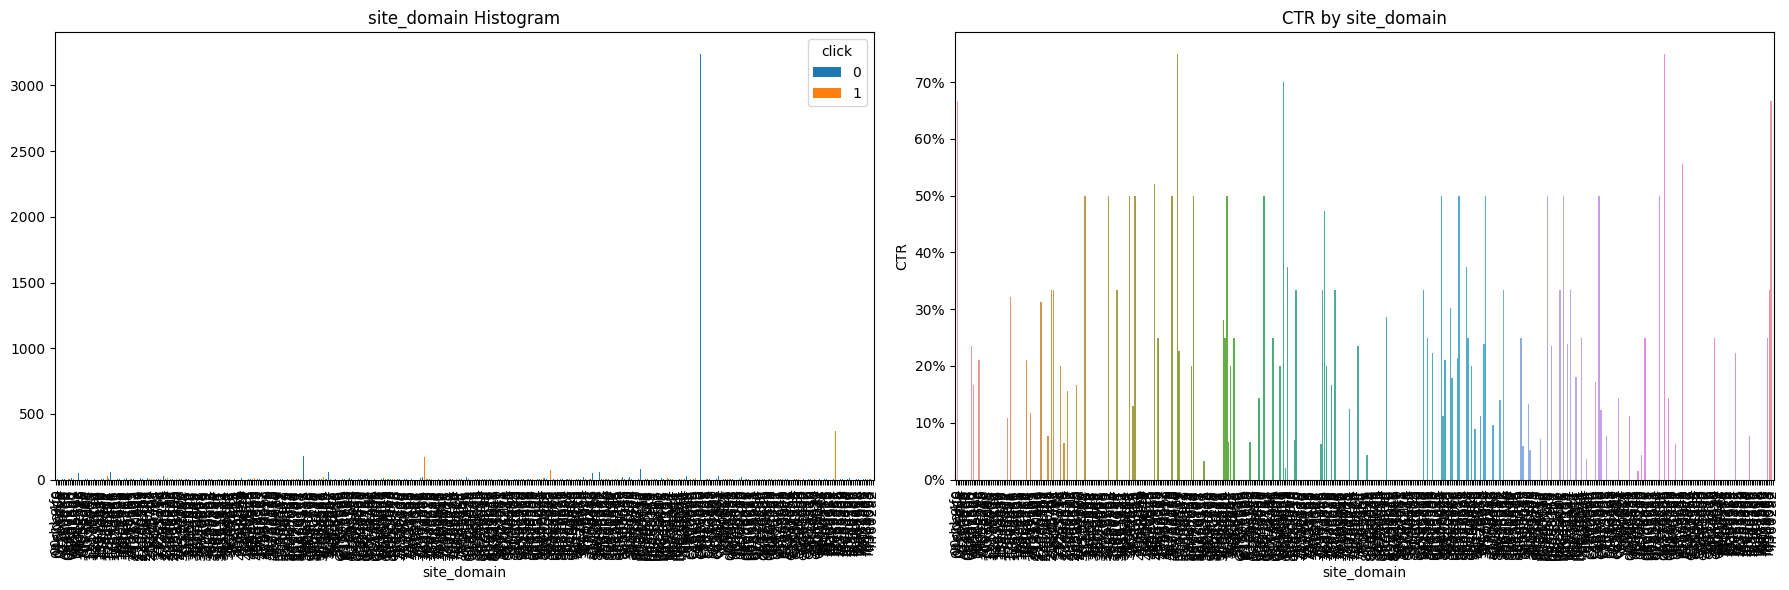

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/3246866625.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


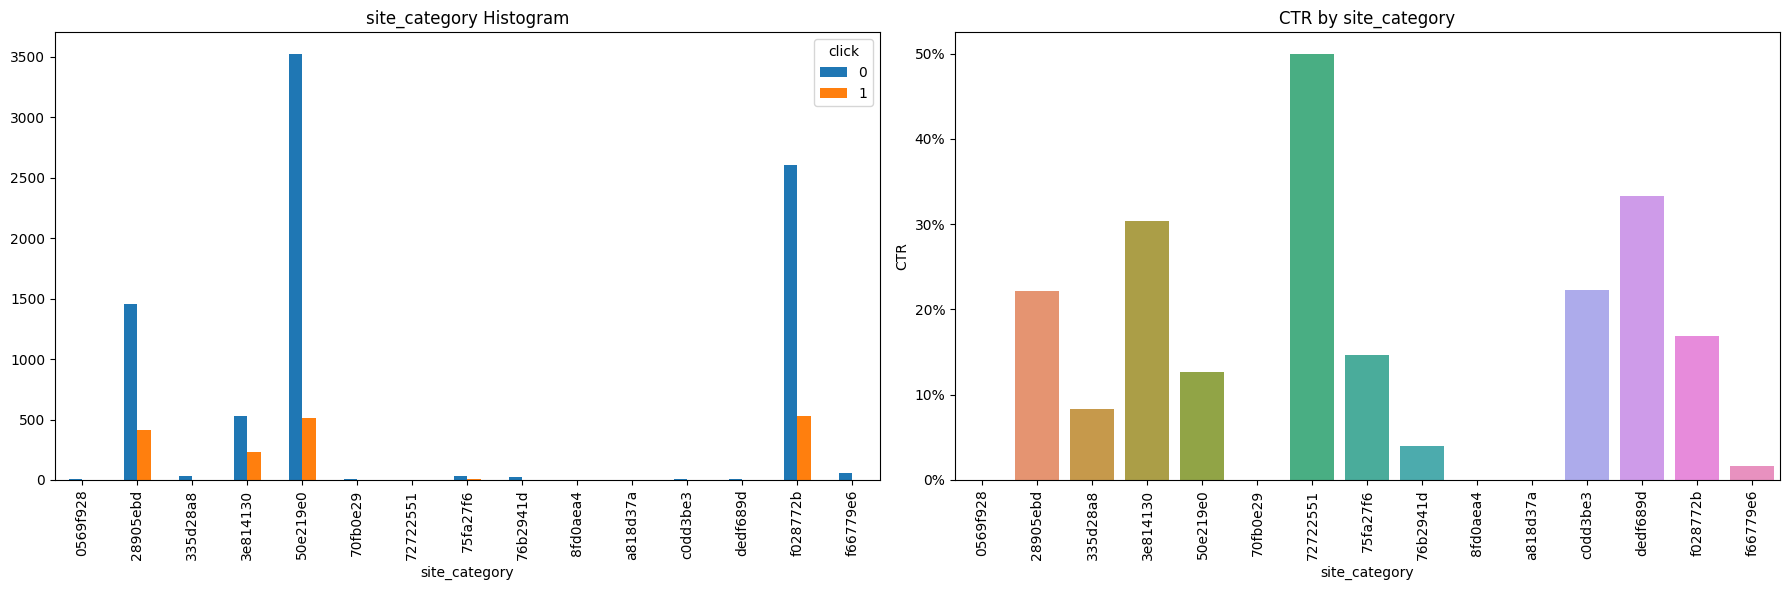

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/3246866625.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


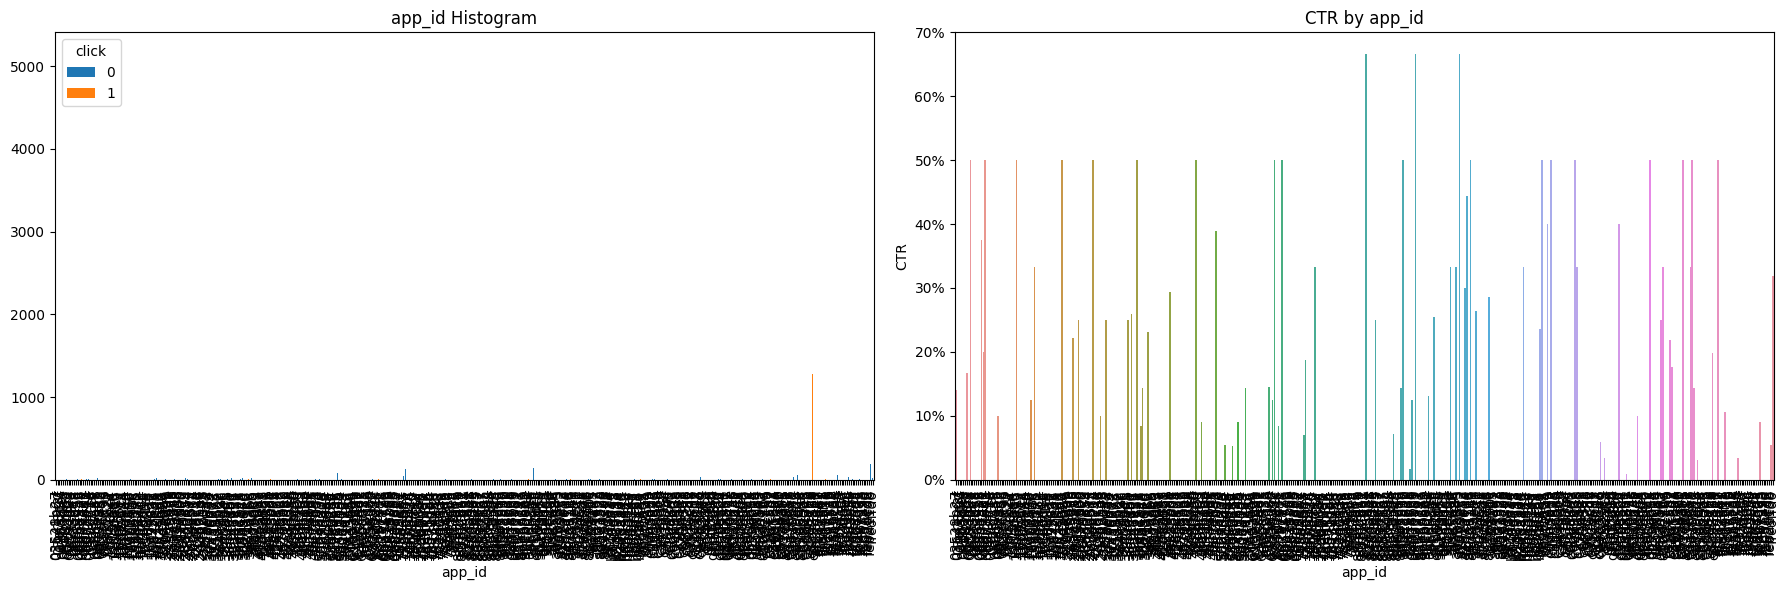

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/3246866625.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


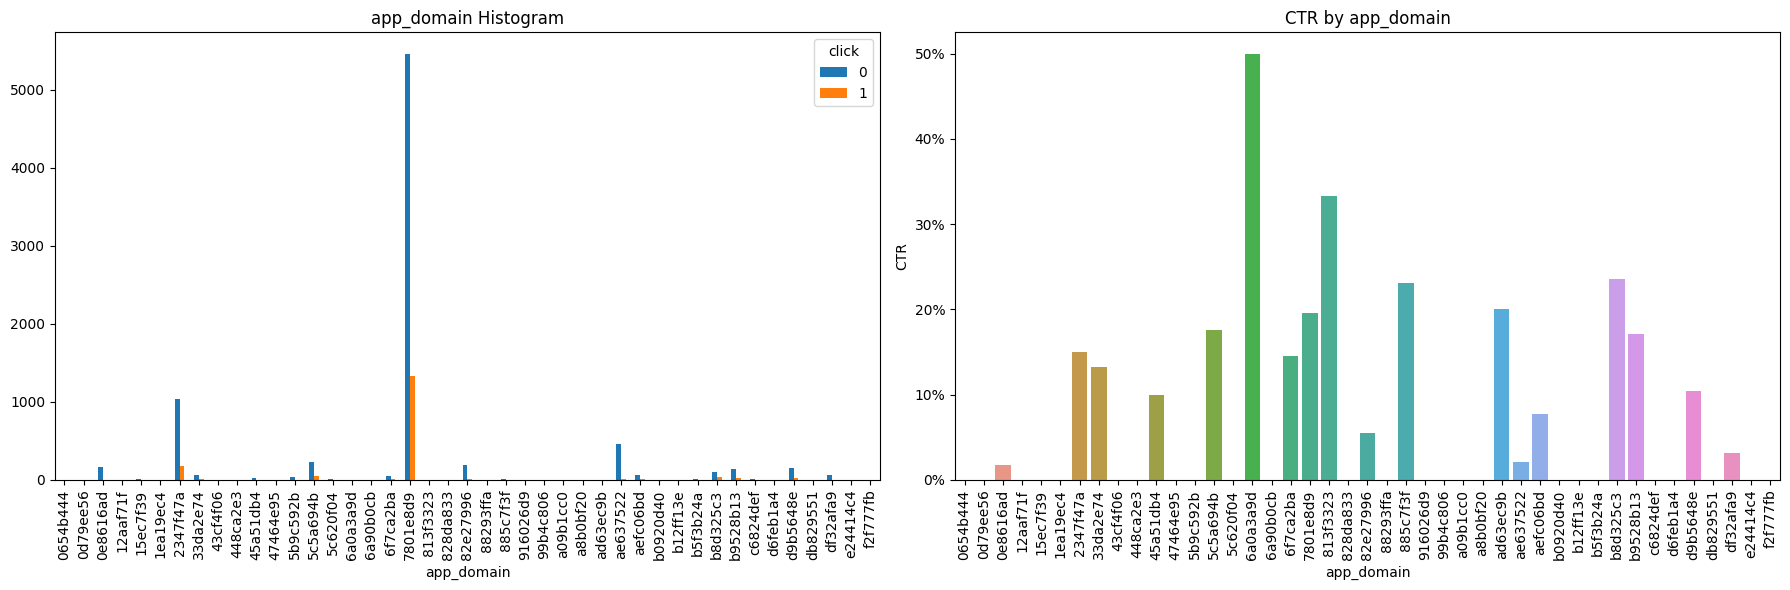

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/3246866625.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


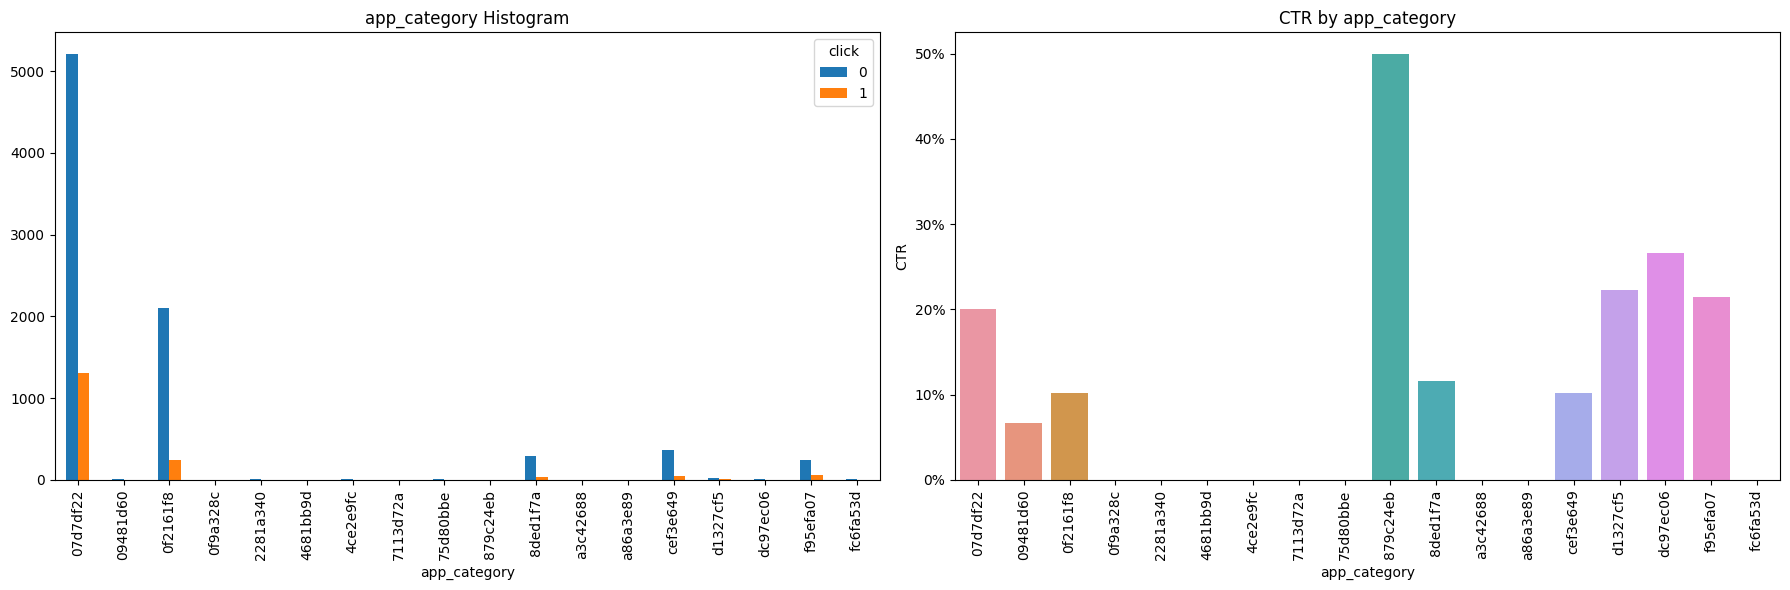

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/3246866625.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


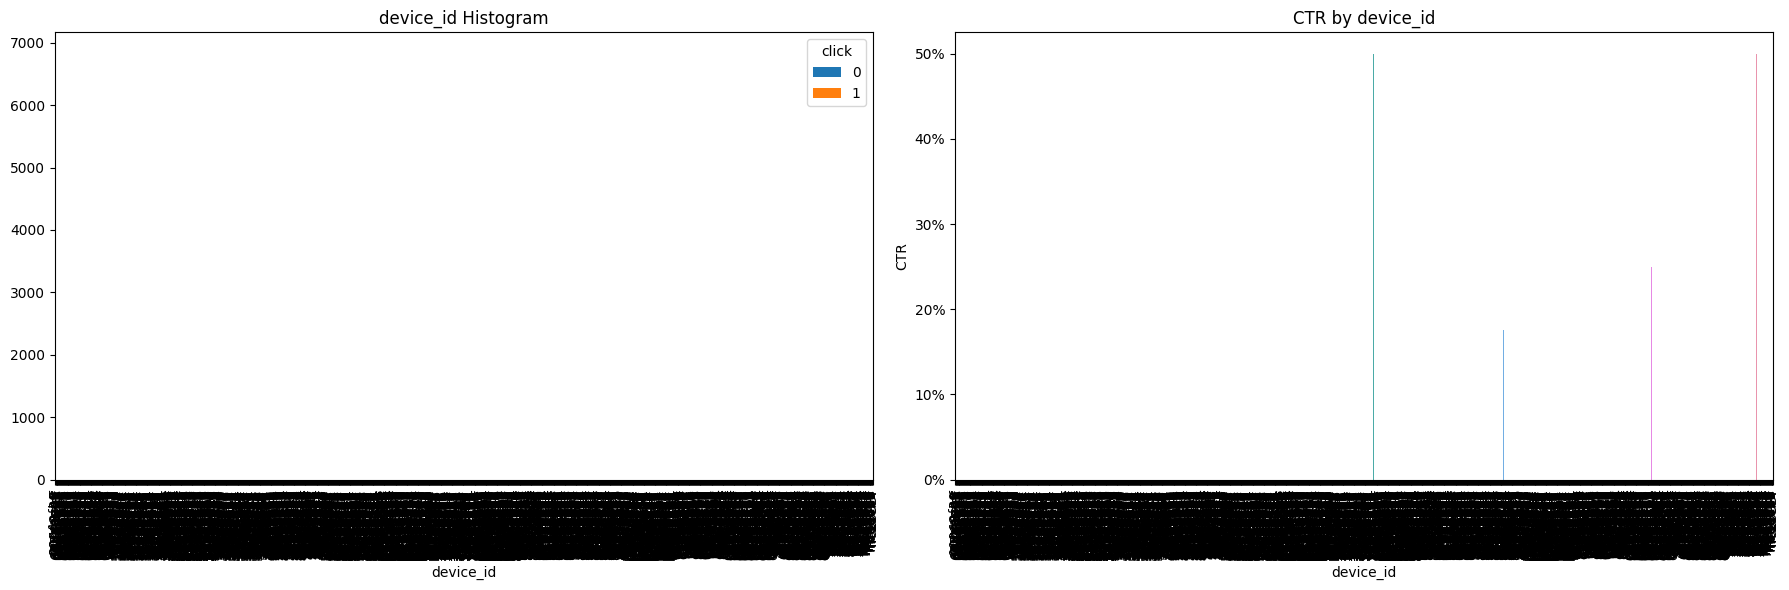

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/3246866625.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


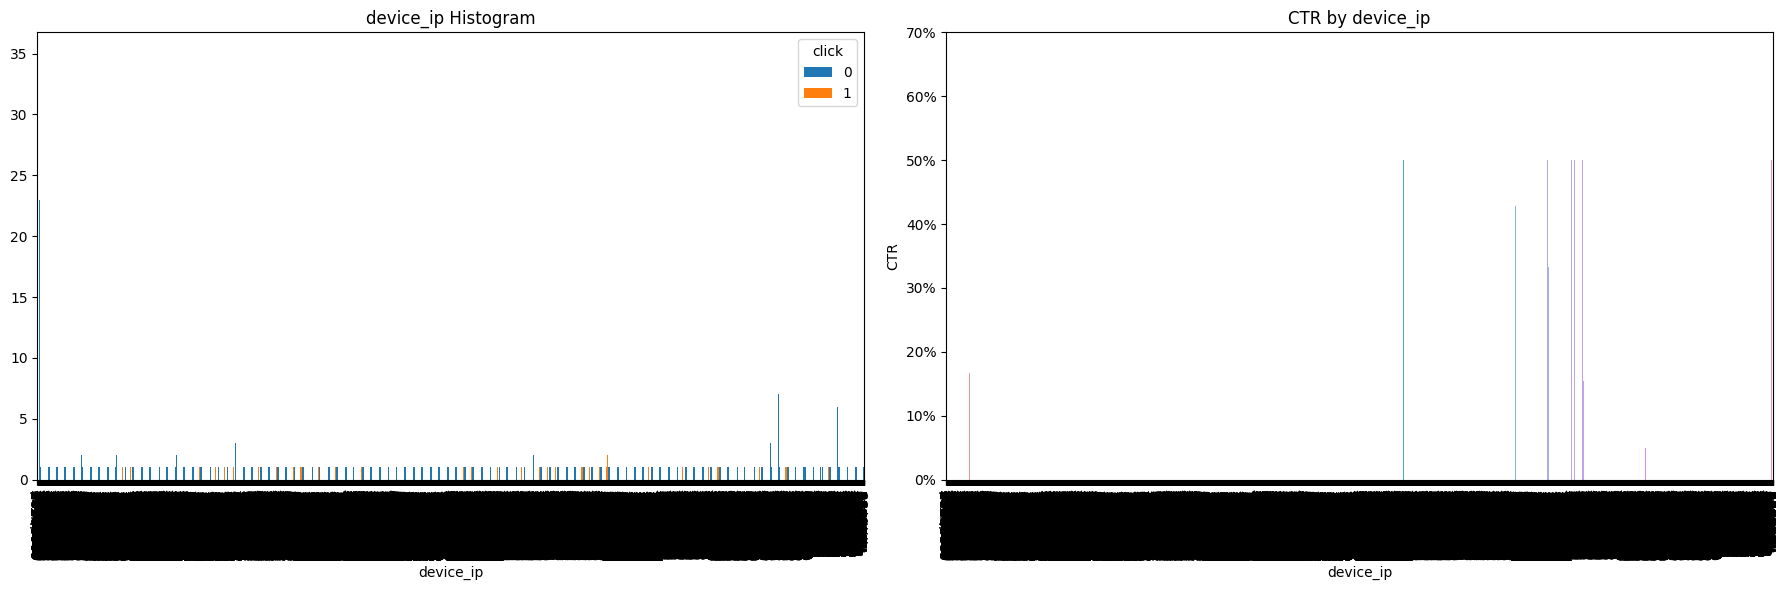

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/3246866625.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


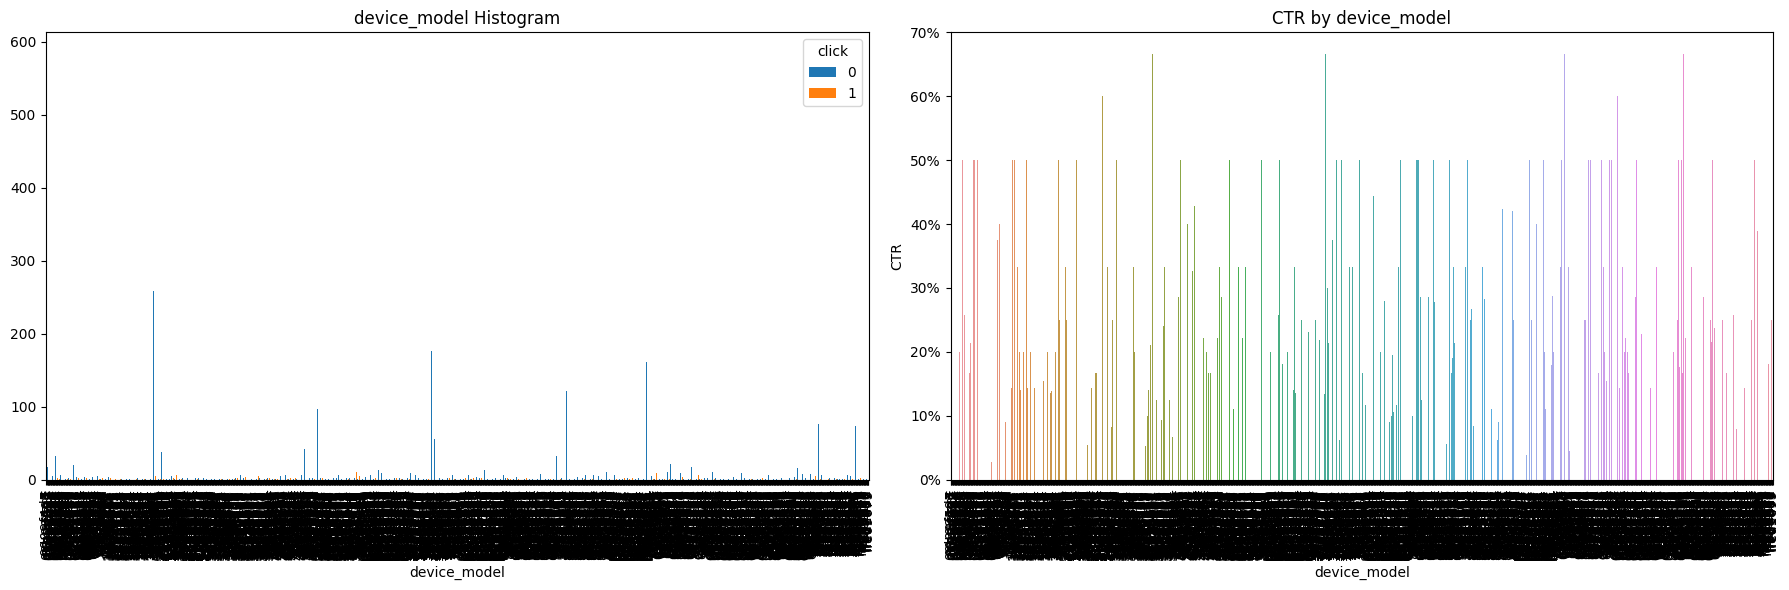

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/3246866625.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


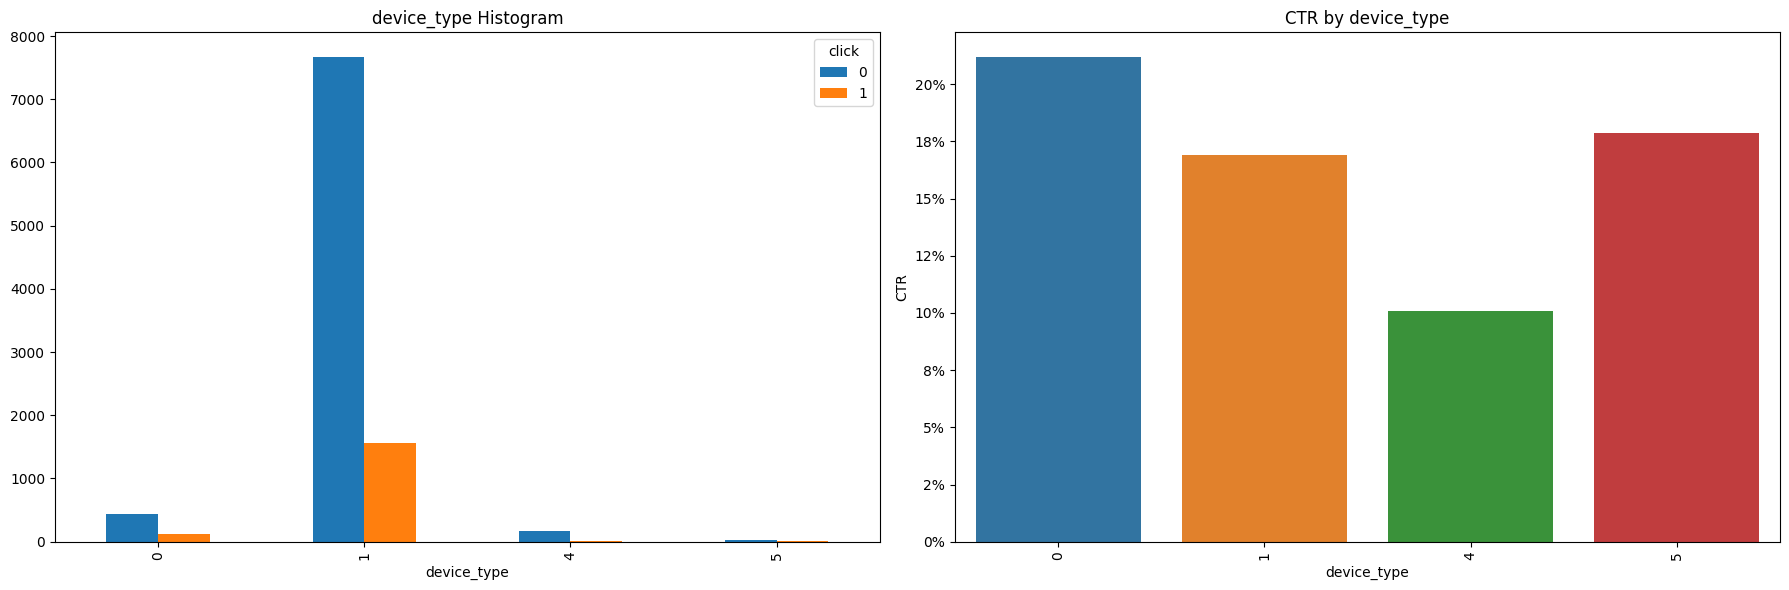

/var/folders/j9/scnjt0d57q3_lzqgdfj4j43r0000gn/T/ipykernel_85283/3246866625.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])


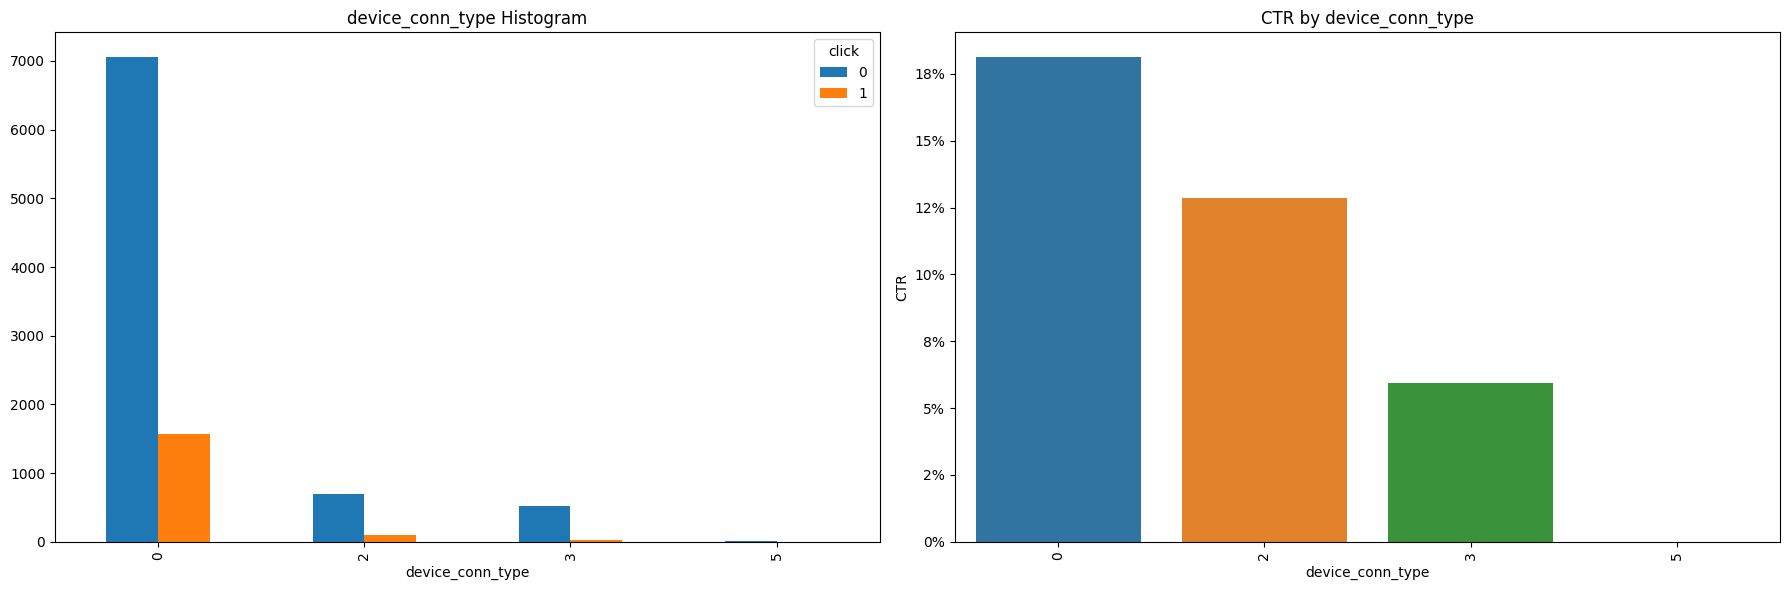

In [19]:
for column in kcf: 
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    # plot the first graph
    train.groupby([column, 'click']).size().unstack().plot(kind='bar', ax=axs[0], title=f'{column} Histogram')
    axs[0].tick_params(axis='x', rotation=90)

    # plot the second graph
    df_col = train.groupby([column, 'click']).size().unstack()
    df_col.reset_index(inplace=True)

    # calculate Click-Through Rate (CTR) per column class
    df_col['CTR'] = df_col[1]/(df_col[1]+df_col[0])*100

    sns.barplot(y='CTR', x=column, data=df_col, ax=axs[1])
    axs[1].set_title(f'CTR by {column}')
    axs[1].set_yticklabels(['{:.0f}%'.format(x) for x in axs[1].get_yticks()])
    axs[1].tick_params(axis='x', rotation=90)


    # adjust the layout and display the graphs
    plt.tight_layout()
    plt.show()

It's hard to say something about most of the features visualized above because they have lots of different categories; device_ip, site_id, site_domain, app_id, device_id, device_ip, and device_model. The device's features are also unreadable from these graphs above. 

These graphs created by the for loop above are used to catch obvious situations inside features at first look in the feature engineering process. For loop is used because every feature is important at the beginning, you can find surprize results although you don't estimate.

But we can analyze some important known features individually. For example, banner position is really an essential factor in advertising. There can be lots of A/B test applications for the position or modification on the color or themes etc. 

In [20]:
# create df to get banner position click values
df_ban = train.groupby(['banner_pos', 'click']).size().unstack()
df_ban.reset_index(inplace=True)

df_ban['total'] = df_ban[1]+df_ban[0]
df_ban['CTR'] = df_ban[1]/df_ban['total']*100

# create for loop to print all position values
for index, row in df_ban.iterrows():
    ban_pos = row['banner_pos']
    total = row['total']
    ctr = row['CTR']
    print(f'For banner position: {ban_pos}, Total number of interaction: {total}, CTR: {ctr}')


For banner position: 0, Total number of interaction: 7215.0, CTR: 16.839916839916842
For banner position: 1, Total number of interaction: 2764.0, CTR: 17.36613603473227
For banner position: 2, Total number of interaction: nan, CTR: nan
For banner position: 3, Total number of interaction: nan, CTR: nan
For banner position: 4, Total number of interaction: 3.0, CTR: 33.33333333333333
For banner position: 5, Total number of interaction: nan, CTR: nan
For banner position: 7, Total number of interaction: 11.0, CTR: 54.54545454545454


According to the values above, although position 7 has the highest CTR percentage, it has only 11 interactions. Of course, increasing the advertising in this position is a good idea but we should be sure what will happen when the interaction increases there. Positions 0 and 1 have higher interaction and CTR values are low. 

Overall, Because of the restricted info about the dataset, not too much information was obtained in the feature engineering part. 

The adjusted dataset is saved below to use for the model development process in the other Jupyter Notebook.

In [138]:
# save subsampled dataset for the model training section

train.to_csv('/dataset/training-dataset-10000.csv', index=False)

**THANK YOU!**